In [2]:
#neccessary imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
import sympy as sy
import sympy.stats
from scipy.stats import norm
import pickle
from timeit import default_timer as timer
from tqdm import tqdm

#not sure
import random
random.seed(100)





$Y = f(X_1, X_2, X_3) = X_1 + X_2 + X_3$ for $X_j \sim \mathcal{U}(0, 2^{j-1})$
\
\
$Y = \mathcal{U}([0,1]) + 2\mathcal{U}([0,1]) + 4\mathcal{U}([0,1])$
\
\
$\rho_{\text{true}}(y) = \text{big piecewise function of lines, parabolas}$
\
\
$\rho(y | \mathcal{G}_{-k}) = \text{piecewise between constant and 0}$


In [64]:
#EXAMPLE 1: weighted sum of uniforms

def theFunc(u):
    return u[0] + 2*u[1] + 4*u[2]

def truePDF(y):
    n = len(y)
    output = [0.0] * n
    for i in range(n):
        if y[i] < 1 and y[i] > 0:
            output[i] = (1 / 16) * y[i]**2
        elif y[i] < 2 and y[i] > 1:
            output[i] = (1 / 16) + (1 / 8) * (y[i] - 1)
        elif y[i] < 3 and y[i] > 2:
            output[i] = (3 / 16) + (3 / 8) * (y[i] - 2) - (1 / 16) * (y[i]**2 - 4)
        elif y[i] < 4 and y[i] > 3:
            output[i] = 1/4
        elif y[i] < 5 and y[i] > 4:
            output[i] = (3 / 16) + (1 / 16) * (1 - (y[i] - 4)**2)
        elif y[i] < 6 and y[i] > 5:
            output[i] = (1 / 16) + (1 / 8) * (6 - y[i])
        elif y[i] < 7 and y[i] > 6:
            output[i] = (3 / 8) * (7 - y[i]) - (1 / 16) * (9 - (y[i] - 4)**2)
        else:
            output[i] = 0
    return output

def conditionalDensity1(y, x):
    test = y - x[1] - x[2]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 1:
            test[j] = 1
        else:
            test[j] = 0
    return test

def conditionalDensity2(y, x):
    test = y - x[0] - x[2]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 2:
            test[j] = 1/2
        else:
            test[j] = 0
    return test

def conditionalDensity3(y, x):
    test = y - x[0] - x[1]
    for j in range(len(test)):
        if test[j] > 0 and test[j] < 4:
            test[j] = 1/4
        else:
            test[j] = 0
    return test

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
start, end, nEval = 0, 7, 100
evalPoints = np.linspace(start, end, nEval)
Q = 25.5323059457 #take bandwidth = (Q / n) **(1/5) generally


$Y = f(X_1, X_2, X_3, X_4) = \frac{1}{\alpha}(\sum_{i=1}^4 X_i) = \frac{1}{\alpha}(\sum_{i=1}^4 w_i Z_i)$ for $\alpha^2 = \sum_{i=1}^4 w_i^2$
\
\
$\rho_{\text{true}}(y) = \phi(x)$
\
\
$\rho(y | \mathcal{G}_{-k}) = \frac{\alpha}{w_k}\phi(\frac{1}{w_k}(\alpha y - \sum_{i\neq k}^4 X_i))$

In [68]:
#EXAMPLE 2: weighted sum of normals

weights = np.array([1, 0.5, 0.25, 0.125])
alpha = np.sqrt(np.sum(weights * weights))

def theFunc(u):
    return np.sum((weights / alpha) * norm.ppf(u))

def truePDF(y):
    return norm.pdf(y)

def conditionalDensity1(y, x):
    return (alpha / weights[0]) * norm.pdf((1 / weights[0]) * (alpha*y - (np.sum(x, 0) - x[0])))

def conditionalDensity2(y, x):
    return (alpha / weights[1]) * norm.pdf((1 / weights[1]) * (alpha*y - (np.sum(x, 0) - x[1])))

def conditionalDensity3(y, x):
    return (alpha / weights[2]) * norm.pdf((1 / weights[2]) * (alpha*y - (np.sum(x, 0) - x[2])))

def conditionalDensity4(y, x):
    return (alpha / weights[3]) * norm.pdf((1 / weights[3]) * (alpha*y - (np.sum(x, 0) - x[3])))

#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return weights[0] * norm.ppf(y)

def inverseCDF2(y):
    return weights[1] * norm.ppf(y)

def inverseCDF3(y):
    return weights[2] * norm.ppf(y)

def inverseCDF4(y):
    return weights[3] * norm.ppf(y)


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3, inverseCDF4]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3, conditionalDensity4]
start, end, nEval = -3, 3, 100
evalPoints = np.linspace(start, end, nEval)
Q = 7.56053742316 #take bandwidth = (Q / n) **(1/5) generally


$Y = f(X_1, X_2, X_3) = X_1X_2X_3$ for $X_j \sim \mathcal{U}(0, 2^{j-1})$
\
\
$\rho_\text{true}(y) = \frac{1}{16}\ln(\frac{y}{8})^2$
\
\
$\rho(y \;|\; \mathcal{G}_{-k}) = (\Pi_{-k})^{-1}$ 

In [120]:
#EXAMPLE 3: weighted product of uniforms


def theFunc(u):
    return 8*u[0]*u[1]*u[2]

def truePDF(y):
    output = [0] * len(y)
    for j in range(len(y)):
        if y[j] > 8 or y[j] < 0:
            output[j] = 0
        else:
            output[j] = (1/16) * (np.log(y[j] / 8))**2
    return output

def conditionalDensity1(y, x):
    test = y / (x[1]*x[2])
    for j in range(len(test)):
        if test[j] > 1 or test[j] < 0:
            test[j]=0
    return test / y

def conditionalDensity2(y, x):
    test = y / (x[0]*x[2])
    for j in range(len(test)):
        if test[j] > 2 or test[j] < 0:
            test[j] = 0
    return test / (2*y)

def conditionalDensity3(y, x):
    test = y / (x[0]*x[1])
    for j in range(len(test)):
        if test[j] > 4 or test[j] < 0:
            test[j] = 0
    return test / (4*y)

def inverseCDF1(y):
    return y

def inverseCDF2(y):
    return 2*y

def inverseCDF3(y):
    return 4*y

start, end = 0.01, 8
nEval = 100
evalPoints = np.linspace(start, end, nEval)
inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
Q = 0.00000565787743961

    


$Y = f(X_1, X_2, X_3) = \frac{4l^3}{X_1wt}\sqrt{{\frac{X_2^2}{w^4}} + {\frac{X_3^2}{t^4}}}$ for $X_j \sim \mathcal{N}(\mu_j, \sigma_j^2)$
\
Want / have to make some simplifications: $X_1 \geq 0$ (happens with probability ~ $10^{-89}$)
\
\
$\rho_\text{true}(y) = ??? \quad \text{isn't known}$
\
\
$\rho(y \; | \; \mathcal{G}_{-k}) = \text{something complicated, a little piecewise, but fully closed form}$

In [13]:
#EXAMPLE 4: Displacement of a cantilever beam



mu = np.array([2.9e+07, 500, 1000])
sigma = np.array([1.45e+06, 100, 100])

l = 100
w = 4
t = 2
kappa = 4*l**3 / (w*t)

def theFunc(u):
    term1 = kappa / (sigma[0] * norm.ppf(u[0]) + mu[0])
    term2 = np.sqrt(((sigma[1] * norm.ppf(u[1]) + mu[1])**2) / (w**4) + ((sigma[2] * norm.ppf(u[2]) + mu[2])**2) / (t**4))
    return term1 * term2


def truePDF(y):
    raise Exception("there is no known truePDF!")
    return True

def conditionalDensity1(y, x):
    def W1(y, x):
        return (kappa / y) * np.sqrt(x[1]**2 / (w**4) + x[2]**2 / (t**4))
    return (1 / (y * sigma[0])) * W1(y,x) * norm.pdf((W1(y, x) - mu[0]) / sigma[0])



def conditionalDensity2(y, x):
    n = len(y)
    output = np.array([0.0] * n)
    def W2(y, x):
        return (w**4) * ((y * x[0] / kappa)**2 - (x[2]**2 / (t**4)))
    
    for i in range(n):
        if W2(y[i], x) <= 0:
            output[i] = 0
        else:
            def sqrtW2(y,x):
                return np.sqrt(W2(y,x))
            
            numer = norm.pdf((sqrtW2(y[i],x) - mu[1]) / sigma[1]) + norm.pdf(-(sqrtW2(y[i],x) + mu[1]) / sigma[1])
            denom = (sigma[1]*sqrtW2(y[i], x)) / ((w**4)*y[i]*(x[0] / kappa)**2)
            output[i] = numer / denom
    return output



def conditionalDensity3(y, x):
    n = len(y)
    output = np.array([0.0] * n)
    def W3(y, x):
        return (t**4) * ((y * x[0] / kappa)**2 - (x[1]**2 / (w**4)))
    
    for i in range(n):
        if W3(y[i], x) <= 0:
            output[i] = 0
        else:
            def sqrtW3(y,x):
                return np.sqrt(W3(y,x))
            
            numer = norm.pdf((sqrtW3(y[i],x) - mu[2]) / sigma[2]) + norm.pdf(-(sqrtW3(y[i],x) + mu[2]) / sigma[2])
            denom = (sigma[2]*sqrtW3(y[i], x)) / ((t**4)*y[i]*(x[0] / kappa)**2)
            output[i] = numer / denom
    return output


#inverseCDFs expect only between (0, 1)
def inverseCDF1(y):
    return sigma[0]*norm.ppf(y) + mu[0]

def inverseCDF2(y):
    return sigma[1]*norm.ppf(y) + mu[1]

def inverseCDF3(y):
    return sigma[2]*norm.ppf(y) + mu[2]


inverseCDFs = [inverseCDF1, inverseCDF2, inverseCDF3]
conditionalDensities = [conditionalDensity1, conditionalDensity2, conditionalDensity3]
start, end, nEval = 3.1707, 5.6675, 100
evalPoints = np.linspace(start, end, nEval)
Q = 1.7364680218 #take bandwidth = (Q / n) **(1/5) generally


In [4]:
def kernelDensityEstimator(y, pointSet, bandwidth): 
    n = len(pointSet)
    def kernel(z): #gaussian kernel
         return np.exp(-z**2) / math.sqrt(math.pi)
    sum = 0
    for i in range(n):
        sum += (1 / (n*bandwidth)) * kernel((y - theFunc(pointSet[i])) / bandwidth)
    return sum

def conditionalEstimator(y, conditionalDensity, realizations):
    output = 0
    for j in range(realizations[:, 0].size):
        output += conditionalDensity(y, realizations[j]) / realizations[:, 0].size
    return output

In [5]:
def getEvaluatedPoints(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints):
    dimension = len(inverseCDFs)
    if n <= 0:
        raise Exception("n must be a positive integer")
    
    if pointSetType == "MC":
        pointSet = qp.IIDStdUniform(dimension).gen_samples(n)
    elif pointSetType == "Sobol":
        pointSet = qp.Sobol(dimension).gen_samples(n)
    else:
        raise Exception("Currently supported pointSetTypes are MC and Sobol")
    if method == "KDE":
        evaluatedPoints = kernelDensityEstimator(evalPoints, pointSet, bandwidth)
    elif method == "conditional":
        realizations = np.array([[0.0] * dimension] * n)
        for i in range(dimension):
            realizations[:, i] = inverseCDFs[i](pointSet[:, i])
        evaluatedPoints = conditionalEstimator(evalPoints, conditionalDensity, realizations)
    else:
        raise Exception("Valid methods are KDE or conditional")
    return evaluatedPoints

def getTrueError(evaluatedPoints, evalPoints):
    nPoints = len(evalPoints)
    estimatedError = ((end - start) / nPoints) * np.sum((evaluatedPoints - truePDF(evalPoints))**2)
    return estimatedError

def averageErrorLog(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, averageAcross, evalPoints):
    sum = 0
    for i in range(averageAcross):
        evaluatedPoints = getEvaluatedPoints(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints)
        sum += (1 / averageAcross) * getTrueError(evaluatedPoints, evalPoints)
    return -np.log10(sum)

In [6]:
def generateSeparatePlots(n, densitiesToPlot, wantTrue, wantSeparate):
    numConditional = len(densitiesToPlot)
    dimension = len(inverseCDFs)

    evaluatedPoints = [0.0] * (numConditional + 1)
    for i in range(numConditional):
        evaluatedPoints[i] = getEvaluatedPoints('Sobol', n, 'conditional', densitiesToPlot[i], "no bandwidth", inverseCDFs, evalPoints)
    

    bandwidth = (Q / n) ** (1/5)
    sobolPoints = qp.Sobol(dimension).gen_samples(n)
    evaluatedPoints[numConditional] = kernelDensityEstimator(evalPoints, sobolPoints, bandwidth)
    
    mpl.style.use('seaborn-v0_8-darkgrid')
    
    if wantSeparate == True:
        fig, ax = plt.subplots(1, numConditional + 1, figsize = (24, 6))
        for i in range(numConditional + 1):
            if i < numConditional:
                name = densitiesToPlot[i].__name__
            else:
                name = "KDE"
            ax[i].plot(evalPoints, evaluatedPoints[i], label = f"{name}", color = "red")
            if wantTrue == True:
                truePoints = truePDF(evalPoints)
                ax[i].plot(evalPoints, truePoints, label = "truePDF", color = "green")
            ax[i].legend() 

    else:
        for i in range(numConditional + 1):
            if i < numConditional:
                name = densitiesToPlot[i].__name__
            else:
                name = "KDE"
            plt.plot(evalPoints, evaluatedPoints[i], "--",label = f"{name}")
        if wantTrue == True:
            truePoints = truePDF(evalPoints)
            plt.plot(evalPoints, truePoints, label = "truePDF", color = "green")
        plt.legend()
        plt.figure(figsize = (16,12))



In [7]:
def printSaveErrorTable(methods, pointSetTypes, conditionalDensities, start, stop, increment, averageOver, Qval, evalPoints):
    db = {}
    xvals = np.array(range(start, stop, increment)) * np.log10(2)
    for method in methods:
        if method == "conditional":
            for conditionalDensity in conditionalDensities:
                for pointSetType in pointSetTypes:
                    output = []
                    for exp in range(start, stop, increment):
                        output.append(averageErrorLog(pointSetType, 2**exp, method, conditionalDensity, "N/A bandwidth", inverseCDFs, averageOver, evalPoints))
                    print(pointSetType, method, conditionalDensity.__name__, output)
                    nu = stats.linregress(xvals, output).slope
                    db[pointSetType, method, conditionalDensity.__name__] = (output, nu)
        elif method == "KDE":
            for pointSetType in pointSetTypes:
                output = []
                for exp in range(start, stop, increment):
                    n = 2**exp
                    output.append(averageErrorLog(pointSetType, n, method, "no conditional density", (Qval / n)**(1/5), inverseCDFs, averageOver, evalPoints))
                print(pointSetType, method, output)
                nu = stats.linregress(xvals, output).slope
                db[pointSetType, method] = (output, nu)
    return db

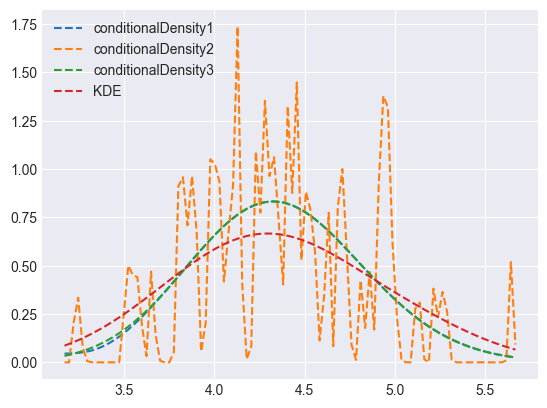

<Figure size 1600x1200 with 0 Axes>

In [17]:
generateSeparatePlots(2**6, [conditionalDensity1, conditionalDensity2, conditionalDensity3], False, False)

In [8]:
def calculateEstimatedMISE(samplePoints):
    predictedVarVec = np.array([0.0] * nEval)
    for j in range(nEval):
        predictedVarVec[j] = np.var(samplePoints[:,j])
    return ((end - start) / nEval) * np.sum(predictedVarVec)

def generatePointsforCalculateEstimatedMISE(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints, nr):
    samplePoints = np.array([[0.0] * nEval] * nr)
    for i in range(nr):
        samplePoints[i] = getEvaluatedPoints(pointSetType, n, method, conditionalDensity, bandwidth, inverseCDFs, evalPoints)
    return samplePoints



In [37]:
nr = 16
dict = {}
expStart, expStop, expIncrement = 4, 10, 1 #4, 10, 1
expVals = np.array(range(expStart, expStop, expIncrement))
for pointSetType in ["Sobol", "MC"]:
    for method in ["conditional"]:
        if method == "conditional":
            for conditionalDensity in conditionalDensities:
                output = []
                for exp in range(expStart, expStop, expIncrement):
                    n = 2**exp
                    output.append(calculateEstimatedMISE(generatePointsforCalculateEstimatedMISE(pointSetType, n, method, conditionalDensity, 
                                                               "no bandwidth", inverseCDFs, evalPoints, nr)))
                logOutput = -np.log2(output)
                slope = stats.linregress(expVals, logOutput).slope
                dict[pointSetType, method, conditionalDensity.__name__] = logOutput, slope
                print(pointSetType, method, conditionalDensity.__name__, logOutput, slope)


Sobol conditional conditionalDensity1 [ 8.82127321 11.30720461 13.32845885 15.35464436 17.84857174 20.9130822 ] 2.345980909881684
Sobol conditional conditionalDensity2 [-0.2648413   0.7579799   1.85915948  3.01014944  4.26700675  5.49130326] 1.1559655235647395
Sobol conditional conditionalDensity3 [13.39525544 15.08481994 17.5347705  19.86435188 22.88515389 24.67962565] 2.347212407397646
MC conditional conditionalDensity1 [4.87312897 5.8224381  6.61166059 7.42416986 8.480331   9.67660379] 0.9372446313433536
MC conditional conditionalDensity2 [-0.38336722  0.63706991  1.68615913  2.74044644  3.60249773  4.69828914] 1.010252930131191
MC conditional conditionalDensity3 [ 8.13385169  8.82145845 10.43839222 11.63514897 11.5882534  13.40001258] 1.0236556017999738


In [10]:
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db

xvals = np.array(range(5, 15, 1))
for conditionalDensity in conditionalDensities:
    output = []
    for exp in range(5, 15 , 1):
        temp = -np.log2(calculateEstimatedMISE(localDb["Sobol", "conditional", conditionalDensity.__name__, exp]))
        output.append(temp)

    print(conditionalDensity.__name__)
    print(f"error for n = 2^14 is {output[-1]}")
    print(f"fitted slope = {stats.linregress(xvals, output).slope}")
dbfile.close()

conditionalDensity1
error for n = 2^14 is 33.003495710549586
fitted slope = 2.440339154837346
conditionalDensity2
error for n = 2^14 is 13.466555006319789
fitted slope = 1.404029137885013
conditionalDensity3
error for n = 2^14 is 36.4828265191413
fitted slope = 2.214254840496351


In [11]:
kdeNR = 16
n = 2**14
bandwidth = 0.365088 * n**(-0.27275)
temp = generatePointsforCalculateEstimatedMISE("Sobol", n, "KDE", "no conditionalDensity", bandwidth, inverseCDFs, evalPoints, kdeNR)
IV = calculateEstimatedMISE(temp)
mean = np.mean(temp, 0)
truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]
ISB = ((end - start) / nEval) *np.sum(mean - truePoints)
print(-np.log2(IV + ISB))


14.020512422507103


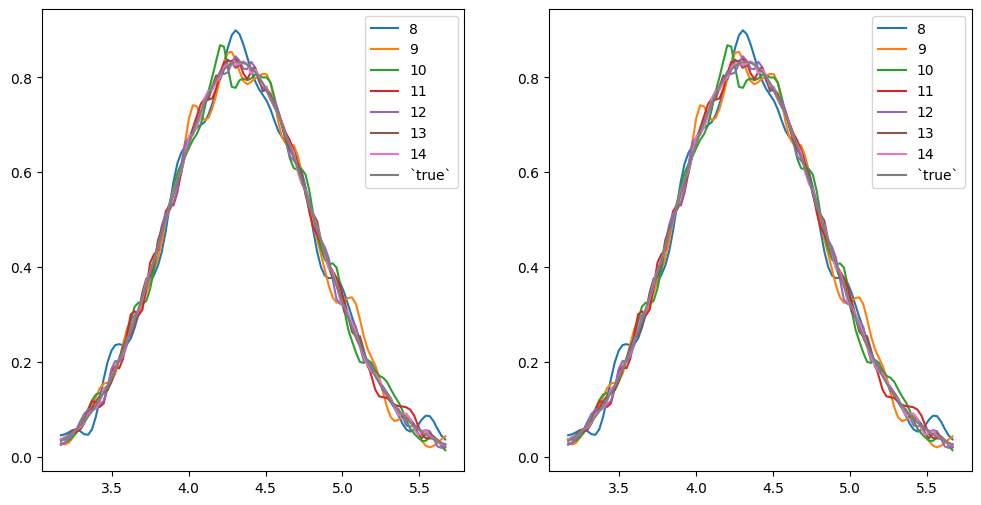

In [12]:
truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
for exp in range(8, 15, 1):
    n = 2**exp
    bandwidth = 0.365088 * n**(-0.27275)
    pts = qp.Sobol(3).gen_samples(n)
    yvals = kernelDensityEstimator(evalPoints, pts, bandwidth)
    ax[0].plot(evalPoints, yvals, label = f"{exp}")
    bandwidthOther = 1.07364680218 / (n**(1/5))
    yvalsOther = kernelDensityEstimator(evalPoints, pts, bandwidth)
    ax[1].plot(evalPoints, yvalsOther, label = f"{exp}")
ax[0].plot(evalPoints, truePoints, label = f"`true`")
ax[1].plot(evalPoints, truePoints, label = f"`true`")
ax[0].legend()
ax[1].legend()


In [29]:
numTest = 10
numRepeat = 10
truePoints = localDb["Sobol", "conditional", "conditionalDensity3", 14][6]

for exp in range(5, 15, 1):
    for qq in range(5):
        lowerBound, upperBound = 0.001, 1
        iterations = 4 
        for j in range(iterations):
            # start = timer()
            minBandwidth = lowerBound
            firstTime = True
            testRange = np.linspace(lowerBound, upperBound, numTest)
            for bandwidth in np.linspace(lowerBound, upperBound, numTest): #tqdm(np.linspace(lowerBound, upperBound, numTest))
                avgError = 0
                for i in range(numRepeat):
                    points = qp.Sobol(3).gen_samples(2**exp)
                    yvals = kernelDensityEstimator(evalPoints, points, bandwidth)
                    squaredError = np.sum((yvals - truePoints)**2)
                    avgError += squaredError / numRepeat
                if firstTime:
                    minError = avgError
                    firstTime = False
                else:
                    if avgError < minError:
                        minError = avgError
                        minBandwidth = bandwidth
            test = np.where(np.array(testRange) ==  minBandwidth)[0][0]
            if test == 0: #to properly address boundary cases
                lowerBound = np.array(testRange)[test]
                upperBound = np.array(testRange)[test+1]
                # print(np.array(testRange)[test], ", ", np.array(testRange)[test+1])
            elif test == numTest - 1:
                # print(np.array(testRange)[test-1], ", ", np.array(testRange)[test])
                lowerBound = np.array(testRange)[test - 1]
                upperBound = np.array(testRange)[test]
            else:
                # print(np.array(testRange)[test-1], ", ", np.array(testRange)[test+1])
                lowerBound = np.array(testRange)[test-1]
                upperBound = np.array(testRange)[test+1]
            # end = timer()
            # print(upperBound - lowerBound)
            # print(f"end of iteration {j + 1} \n", end - start, "\n")

        # print("global min stuff")
        # print(lowerBound, upperBound)
        print(exp, minBandwidth)



    

5 0.3091810699588477
5 0.3566872427983539
5 0.2744650205761317
5 0.35272839506172843
5 0.30765843621399175
6 0.2365514403292181
6 0.21584362139917695
6 0.25725925925925924
6 0.25878189300411525
6 0.24507818930041153
7 0.1945267489711934
7 0.2243703703703704
7 0.2039670781893004
7 0.21249382716049384
7 0.21158024691358024
8 0.1619423868312757
8 0.17899588477366254
8 0.15630864197530864
8 0.18691358024691357
8 0.186
9 0.13255555555555554
9 0.1295102880658436
9 0.14534567901234566
9 0.13164197530864197
9 0.13286008230452676
10 0.11489300411522634
10 0.10088477366255144
10 0.11672016460905349
10 0.11002057613168724
10 0.11306584362139918
11 0.09936213991769548


KeyboardInterrupt: 

Text(0.5, 1.0, 'mean = 4.36 and std = 0.48')

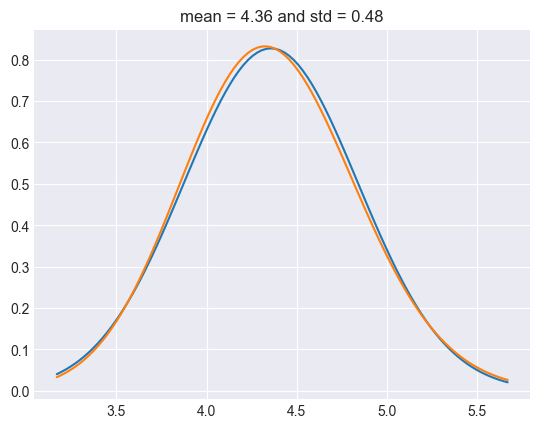

In [223]:
n = 2**23
sobolPoints = qp.Sobol(3).gen_samples(n)
samples = theFunc((sobolPoints[:, 0], sobolPoints[:, 1], sobolPoints[:, 2]))
samples

mean, std = norm.fit(samples)
fig, ax = plt.subplots()
plt.plot(evalPoints, norm.pdf(evalPoints, mean, std))
plt.plot(evalPoints, localDb["Sobol", "conditional", "conditionalDensity3", 14][6])
ax.set_title(f"mean = {round(mean, 2)} and std = {round(std, 2)}")

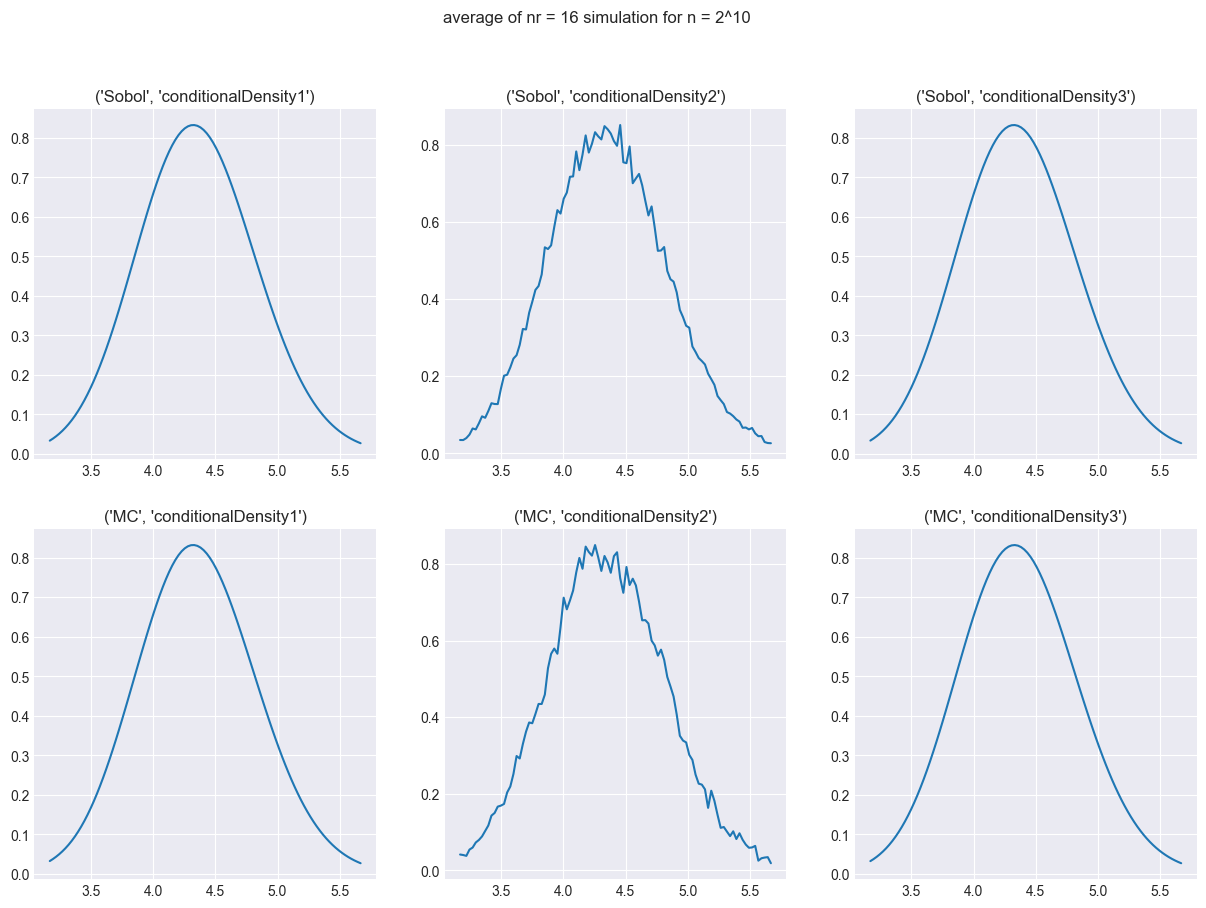

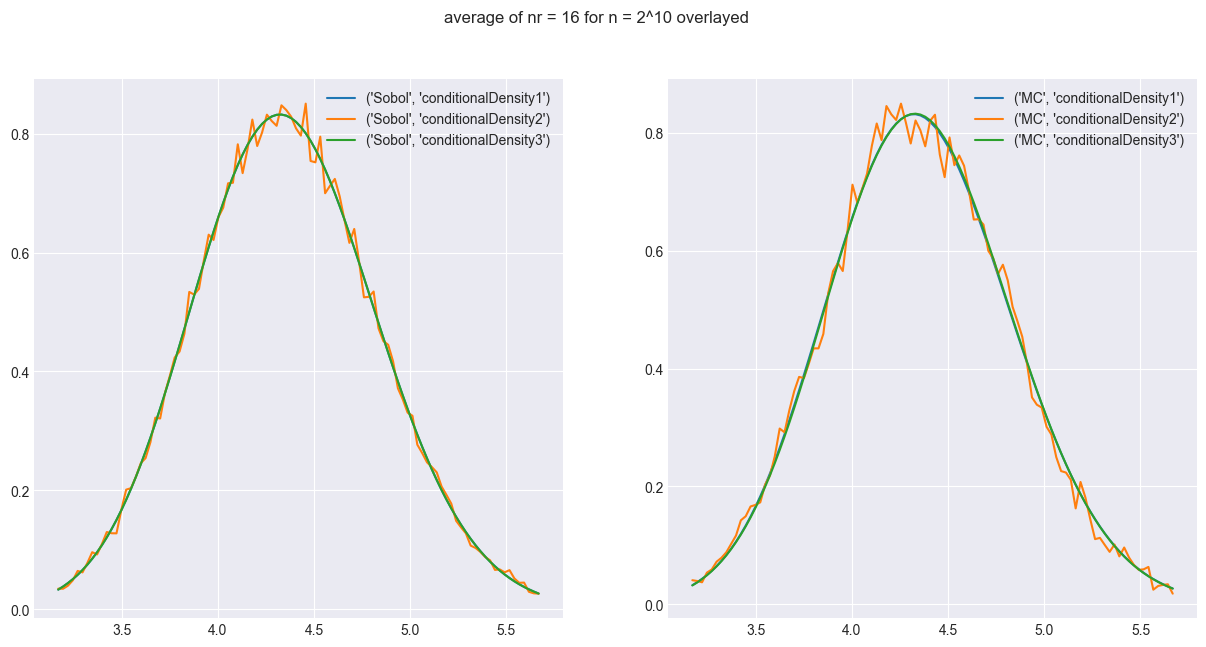

In [153]:
fig, ax = plt.subplots(2, 3, figsize = (15, 10))
fig.suptitle("average of nr = 16 simulation for n = 2^10")
figAll, axAll = plt.subplots(1, 2, figsize = (15, 7))
figAll.suptitle("average of nr = 16 for n = 2^10 overlayed")
exp = 10
for pointSetType in ["MC", "Sobol"]:
    for i in range(3):
        conditionalDensity = conditionalDensities[i]
        yvals = np.sum(localDb[pointSetType, "conditional", conditionalDensity.__name__, exp], 0) / nr
        if pointSetType == "Sobol":
            ax[0][i].plot(evalPoints, yvals)
            ax[0][i].set_title(f"{pointSetType, conditionalDensities[i].__name__}")
            axAll[0].plot(evalPoints, yvals, label = f"{pointSetType, conditionalDensity.__name__}")
            axAll[0].legend()
        if pointSetType == "MC":
            ax[1][i].plot(evalPoints, yvals)
            ax[1][i].set_title(f"{pointSetType, conditionalDensities[i].__name__}")
            axAll[1].plot(evalPoints, yvals, label = f"{pointSetType, conditionalDensity.__name__}")
            axAll[1].legend()


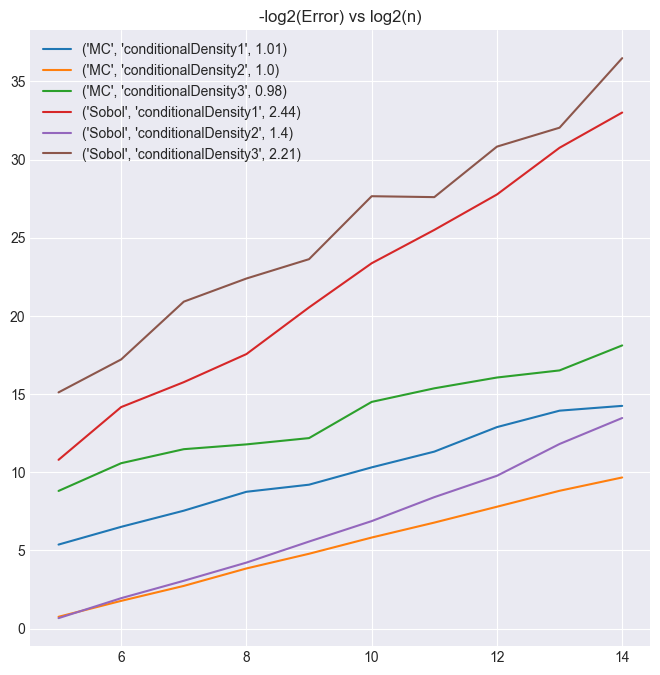

In [128]:
xvals = np.array(range(5, 15, 1))
fig, ax = plt.subplots(figsize = (8,8))
for pointSetType in ["MC", "Sobol"]:
    for conditionalDensity in conditionalDensities:
        errorVals = []
        for exp in range(5, 15 , 1):
            temp = -np.log2(calculateEstimatedMISE(localDb[pointSetType, "conditional", conditionalDensity.__name__, exp]))
            errorVals.append(temp)
        plt.plot(xvals, errorVals, label = f"{pointSetType, conditionalDensity.__name__, round(stats.linregress(xvals, errorVals).slope, 2)}")
        plt.legend()
        ax.set_title("-log2(Error) vs log2(n)")

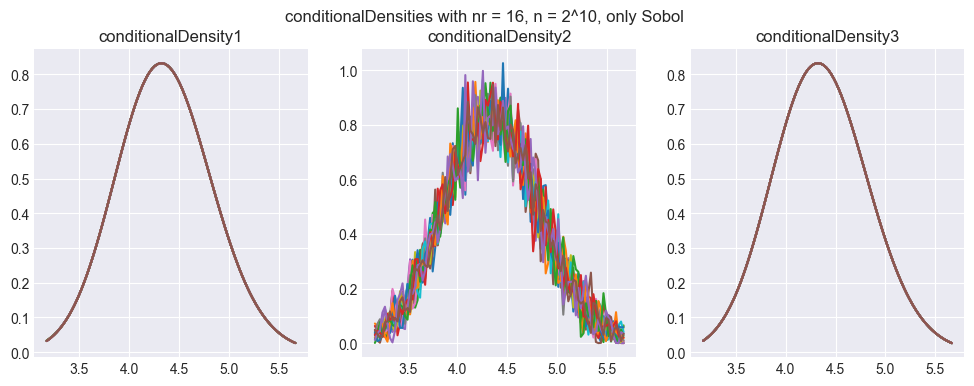

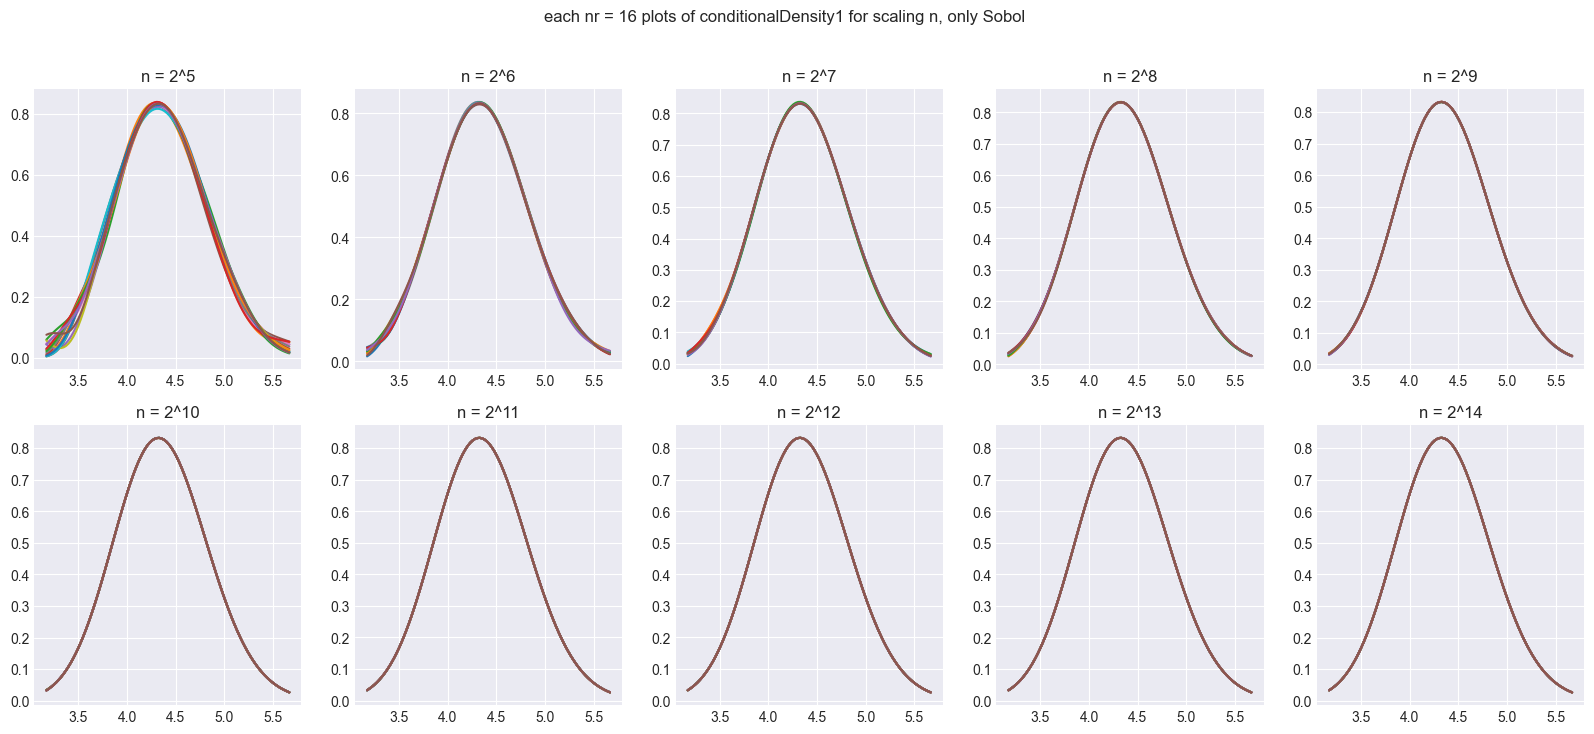

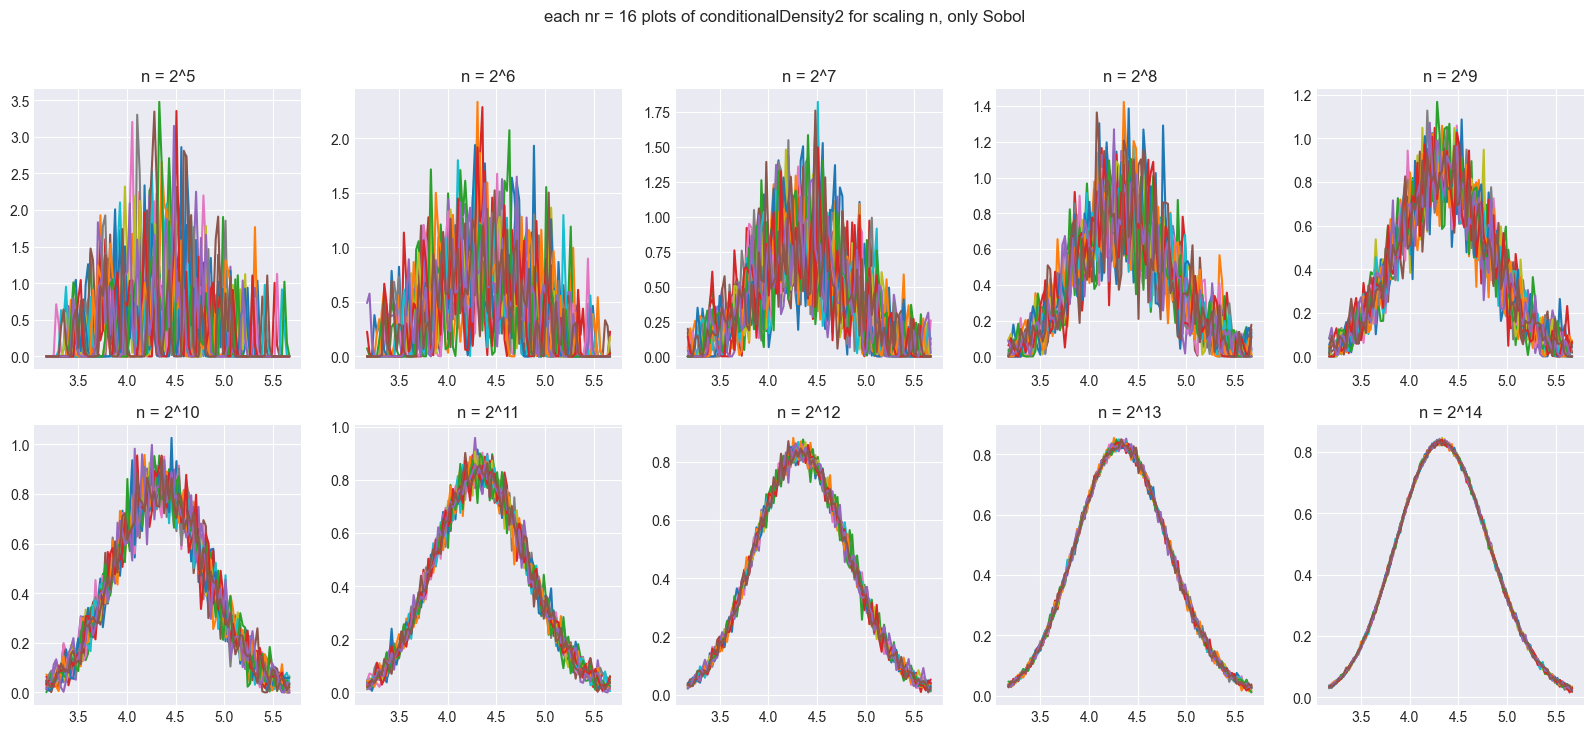

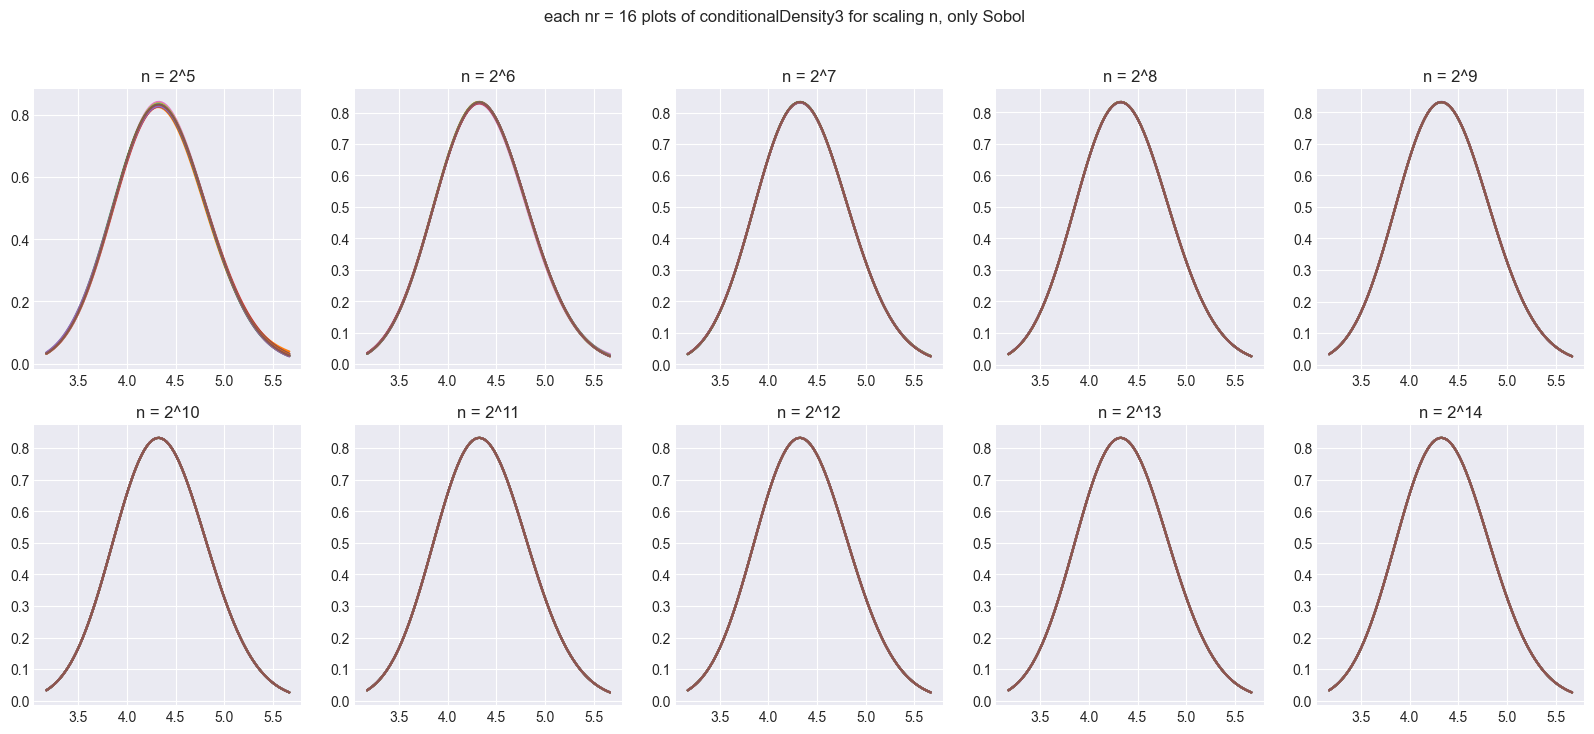

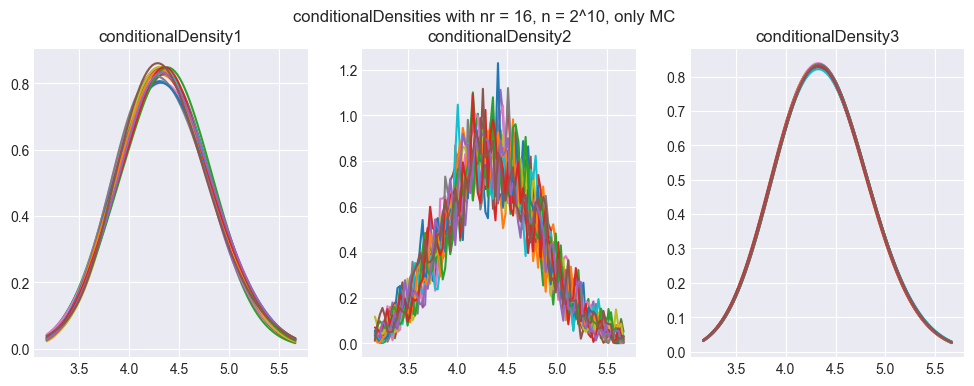

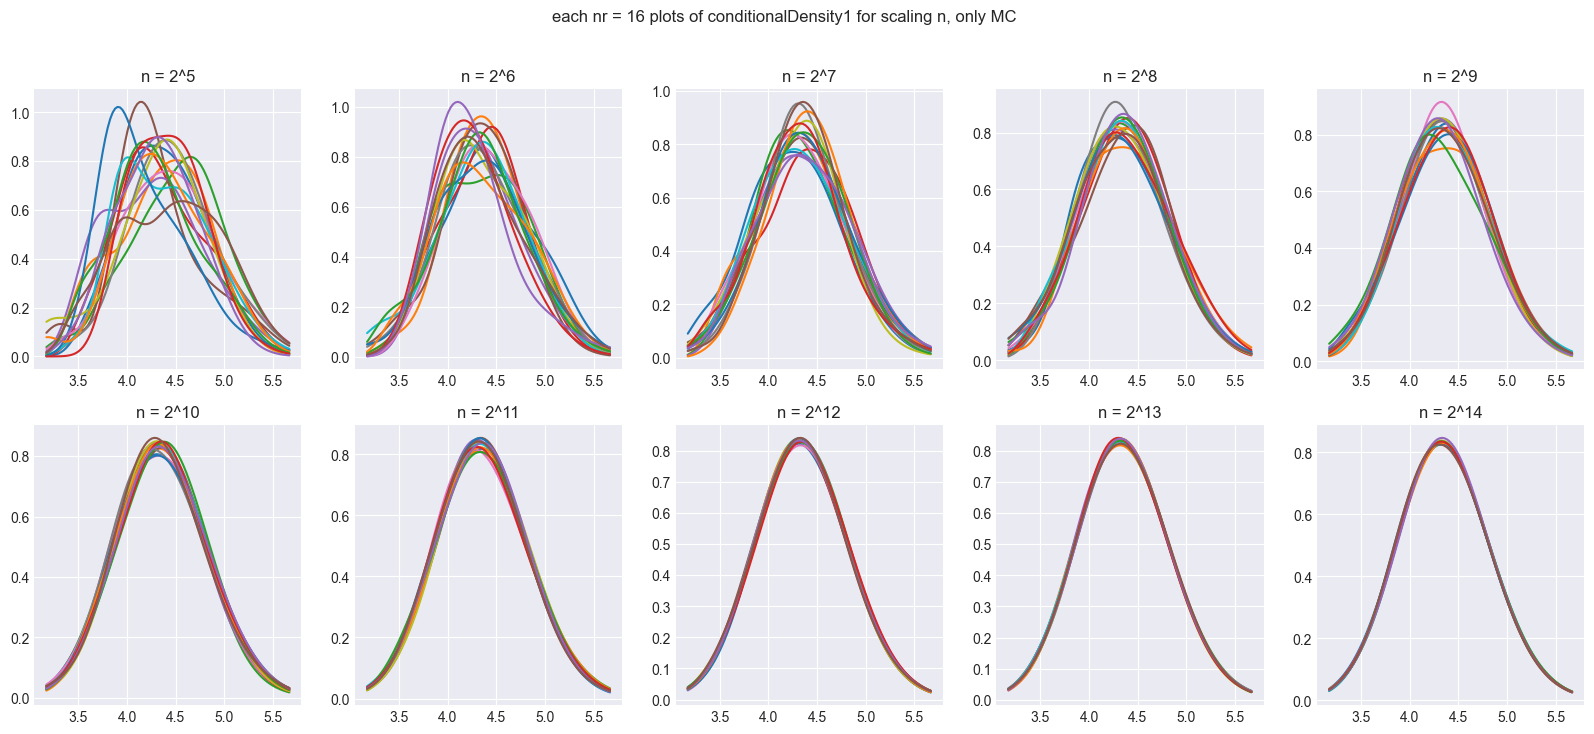

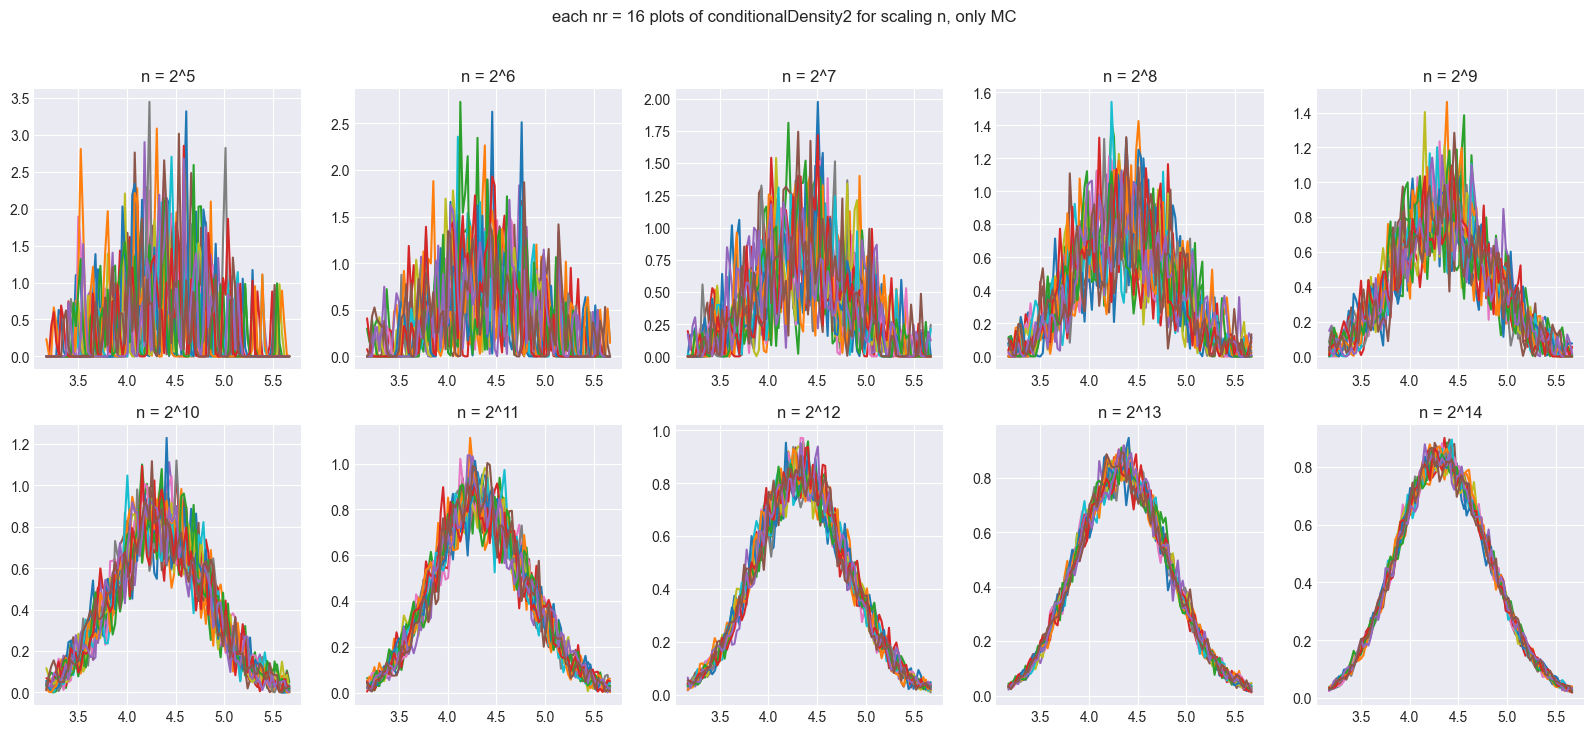

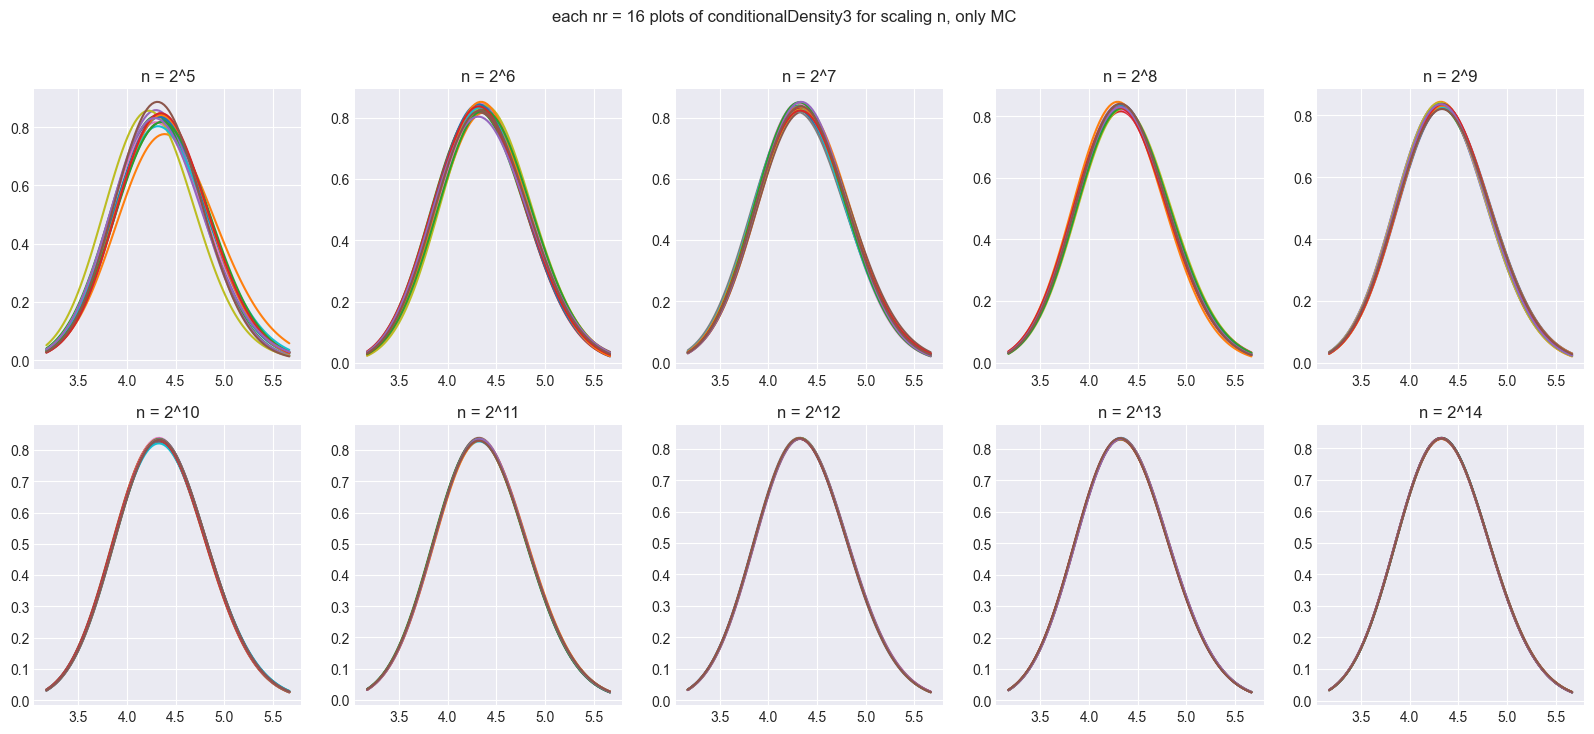

In [129]:
dbfile = open('experiment2Corrected', 'rb')
db = pickle.load(dbfile)
localDb = db
for pointSetType in ["Sobol", "MC"]:
    fig, ax = plt.subplots(1, 3, figsize = (12, 4))
    fig.suptitle(f"conditionalDensities with nr = 16, n = 2^10, only {pointSetType}")
    for key in localDb:
        if key[0] == pointSetType:
            for i in range(nr):
                if key[2] == "conditionalDensity1" and key[3] == 10:
                    ax[0].plot(evalPoints, localDb[key][i])
                    ax[0].set_title("conditionalDensity1")
                elif key[2] == "conditionalDensity2" and key[3] == 10:
                    ax[1].plot(evalPoints, localDb[key][i])
                    ax[1].set_title("conditionalDensity2")
                elif key[2] == "conditionalDensity3" and key[3] == 10:
                    ax[2].plot(evalPoints, localDb[key][i])
                    ax[2].set_title("conditionalDensity3")

    for conditionalDensity in conditionalDensities:
        fig, ax = plt.subplots(2, 5, figsize = (20, 8))
        fig.suptitle(f"each nr = 16 plots of {conditionalDensity.__name__} for scaling n, only {pointSetType}")
        for exp in range(5, 15, 1):
            for i in range(nr):
                if exp - 5 < 5:
                    ax[0][exp - 5].plot(evalPoints, localDb[pointSetType, "conditional", conditionalDensity.__name__, exp][i])
                    ax[0][exp - 5].set_title(f"n = 2^{exp}")
                elif exp - 5 >= 5:
                    ax[1][exp - 10].plot(evalPoints, localDb[pointSetType, "conditional", conditionalDensity.__name__, exp][i])
                    ax[1][exp - 10].set_title(f"n = 2^{exp}")

dbfile.close()

In [19]:
# nr = 16
# dict = {}
# expStart, expStop, expIncrement = 5, 15, 1
# expVals = np.array(range(expStart, expStop, expIncrement))
# for pointSetType in ["Sobol", "MC"]:
#     for method in ["conditional"]:
#         if method == "conditional":
#             for conditionalDensity in conditionalDensities:
#                 for exp in range(expStart, expStop, expIncrement):
#                     start = timer()
#                     n = 2**exp
#                     dict[pointSetType, method, conditionalDensity.__name__, exp] = generatePointsforCalculateEstimatedMISE(pointSetType, n, method, conditionalDensity, 
#                                                                "no bandwidth", inverseCDFs, evalPoints, nr)
#                     end = timer()
#                     print(pointSetType, method, conditionalDensity.__name__, exp, end - start)

# dbfile = open('experiment2Corrected', 'ab')
# pickle.dump(dict, dbfile)
# dbfile.close()

# dbfile = open('experiment2Corrected' 'rb')
# db = pickle.load(dbfile)
# localDb = db
# print(localDb)
# dbfile.close()




Sobol conditional conditionalDensity1 5 0.9117463000584394
Sobol conditional conditionalDensity1 6 0.9789173998869956
Sobol conditional conditionalDensity1 7 0.944187399931252
Sobol conditional conditionalDensity1 8 1.2597777000628412
Sobol conditional conditionalDensity1 9 1.6913501999806613
Sobol conditional conditionalDensity1 10 2.2935220000799745
Sobol conditional conditionalDensity1 11 3.8827366000041366
Sobol conditional conditionalDensity1 12 6.864199500065297
Sobol conditional conditionalDensity1 13 12.736009099986404
Sobol conditional conditionalDensity1 14 23.783381700050086
Sobol conditional conditionalDensity2 5 5.039157799910754
Sobol conditional conditionalDensity2 6 9.03002139995806
Sobol conditional conditionalDensity2 7 18.070260199951008
Sobol conditional conditionalDensity2 8 35.72036699997261
Sobol conditional conditionalDensity2 9 68.0065420998726
Sobol conditional conditionalDensity2 10 134.27439419995062
Sobol conditional conditionalDensity2 11 279.2187409999314

FileNotFoundError: [Errno 2] No such file or directory: 'experiment2Correctedrb'

(array([ 2.,  1.,  4.,  6., 13., 27., 39., 25., 20., 13.]),
 array([-7.19626200e-04, -6.16011493e-04, -5.12396785e-04, -4.08782078e-04,
        -3.05167370e-04, -2.01552663e-04, -9.79379551e-05,  5.67675241e-06,
         1.09291460e-04,  2.12906167e-04,  3.16520875e-04]),
 <BarContainer object of 10 artists>)

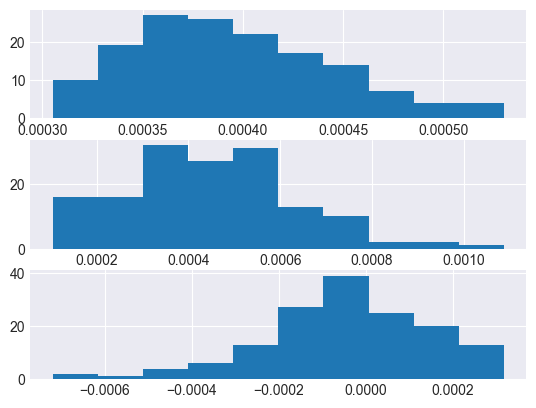

In [120]:
testing = 150
list1 = np.array([0.0] * testing)
list2 = np.array([0.0] * testing)
nr = 10
for i in range(testing):
    list1[i] = calculateEstimatedMISE(generatePointsforCalculateEstimatedMISE('Sobol', 2**8, "conditional", conditionalDensity3, "no bandwidth", inverseCDFs, evalPoints, nr))
    list2[i] = getTrueError(getEvaluatedPoints('Sobol', 2**8, "conditional", conditionalDensity3, "no bandwidth", inverseCDFs, evalPoints), evalPoints)

fig, ax = plt.subplots(3)
ax[0].hist(list1)
ax[1].hist(list2)
ax[2].hist(list1 - list2)



In [25]:
dbFromGithub = {
    ('MC', 'conditional', 'conditionalDensity1') : ([3.1232477800396206, 3.8096834805839217, 4.2891843930376, 4.843869774778309, 5.526437006878188, 6.209478583144208], 1.0030372046729858),
    ('Sobol', 'conditional', 'conditionalDensity1') : ([4.399018936933285, 5.373626582282403, 6.143926972187371, 7.016837233083066, 8.225135407609418, 9.006651742476551], 1.5406913042471198),
    ('MC', 'conditional', 'conditionalDensity2') : ([3.625000985625958, 4.172391330853257, 4.668379291096744, 5.372872963626329, 5.956312031592263, 6.497775034830397], 0.9690598618504621),
    ('Sobol', 'conditional', 'conditionalDensity2') : ([5.074725809305252, 6.103895697002305, 7.155159995045782, 8.157761958698922, 8.842973088864314, 9.632363800222102], 1.5189764928443374),
    ('MC', 'conditional', 'conditionalDensity3') : ([4.391199385256805, 5.158770030718988, 5.53149954209471, 6.070369359959053, 6.832584785774641, 7.289932749585252], 0.9516840368795674),
    ('Sobol', 'conditional', 'conditionalDensity3') : ([5.926770744325015, 6.889222492963222, 7.573849478421692, 8.707904250104782, 9.613872019657054, 10.367627399410905], 1.4954507183002743),
    ('MC', 'KDE') : ([3.0876806897943423, 3.574773548377169, 4.091940154917854, 4.5393756293950505, 5.008885740021845, 5.410285937604495], 0.7765148477916677),
    ('Sobol', 'KDE') : ([3.812520461104638, 4.263305901753035, 4.726315681785227, 5.194612460816758, 5.661160362579009, 6.13288393785781], 0.7718109623405544)
}

#pickle file got corrupted (my fault) so I got this from the github repo
#these were the results of experiment1 (weighted sum of normals)

In [9]:
dbfile = open("experiment1", "rb")
loadedDb = pickle.load(dbfile)
dbfile.close()

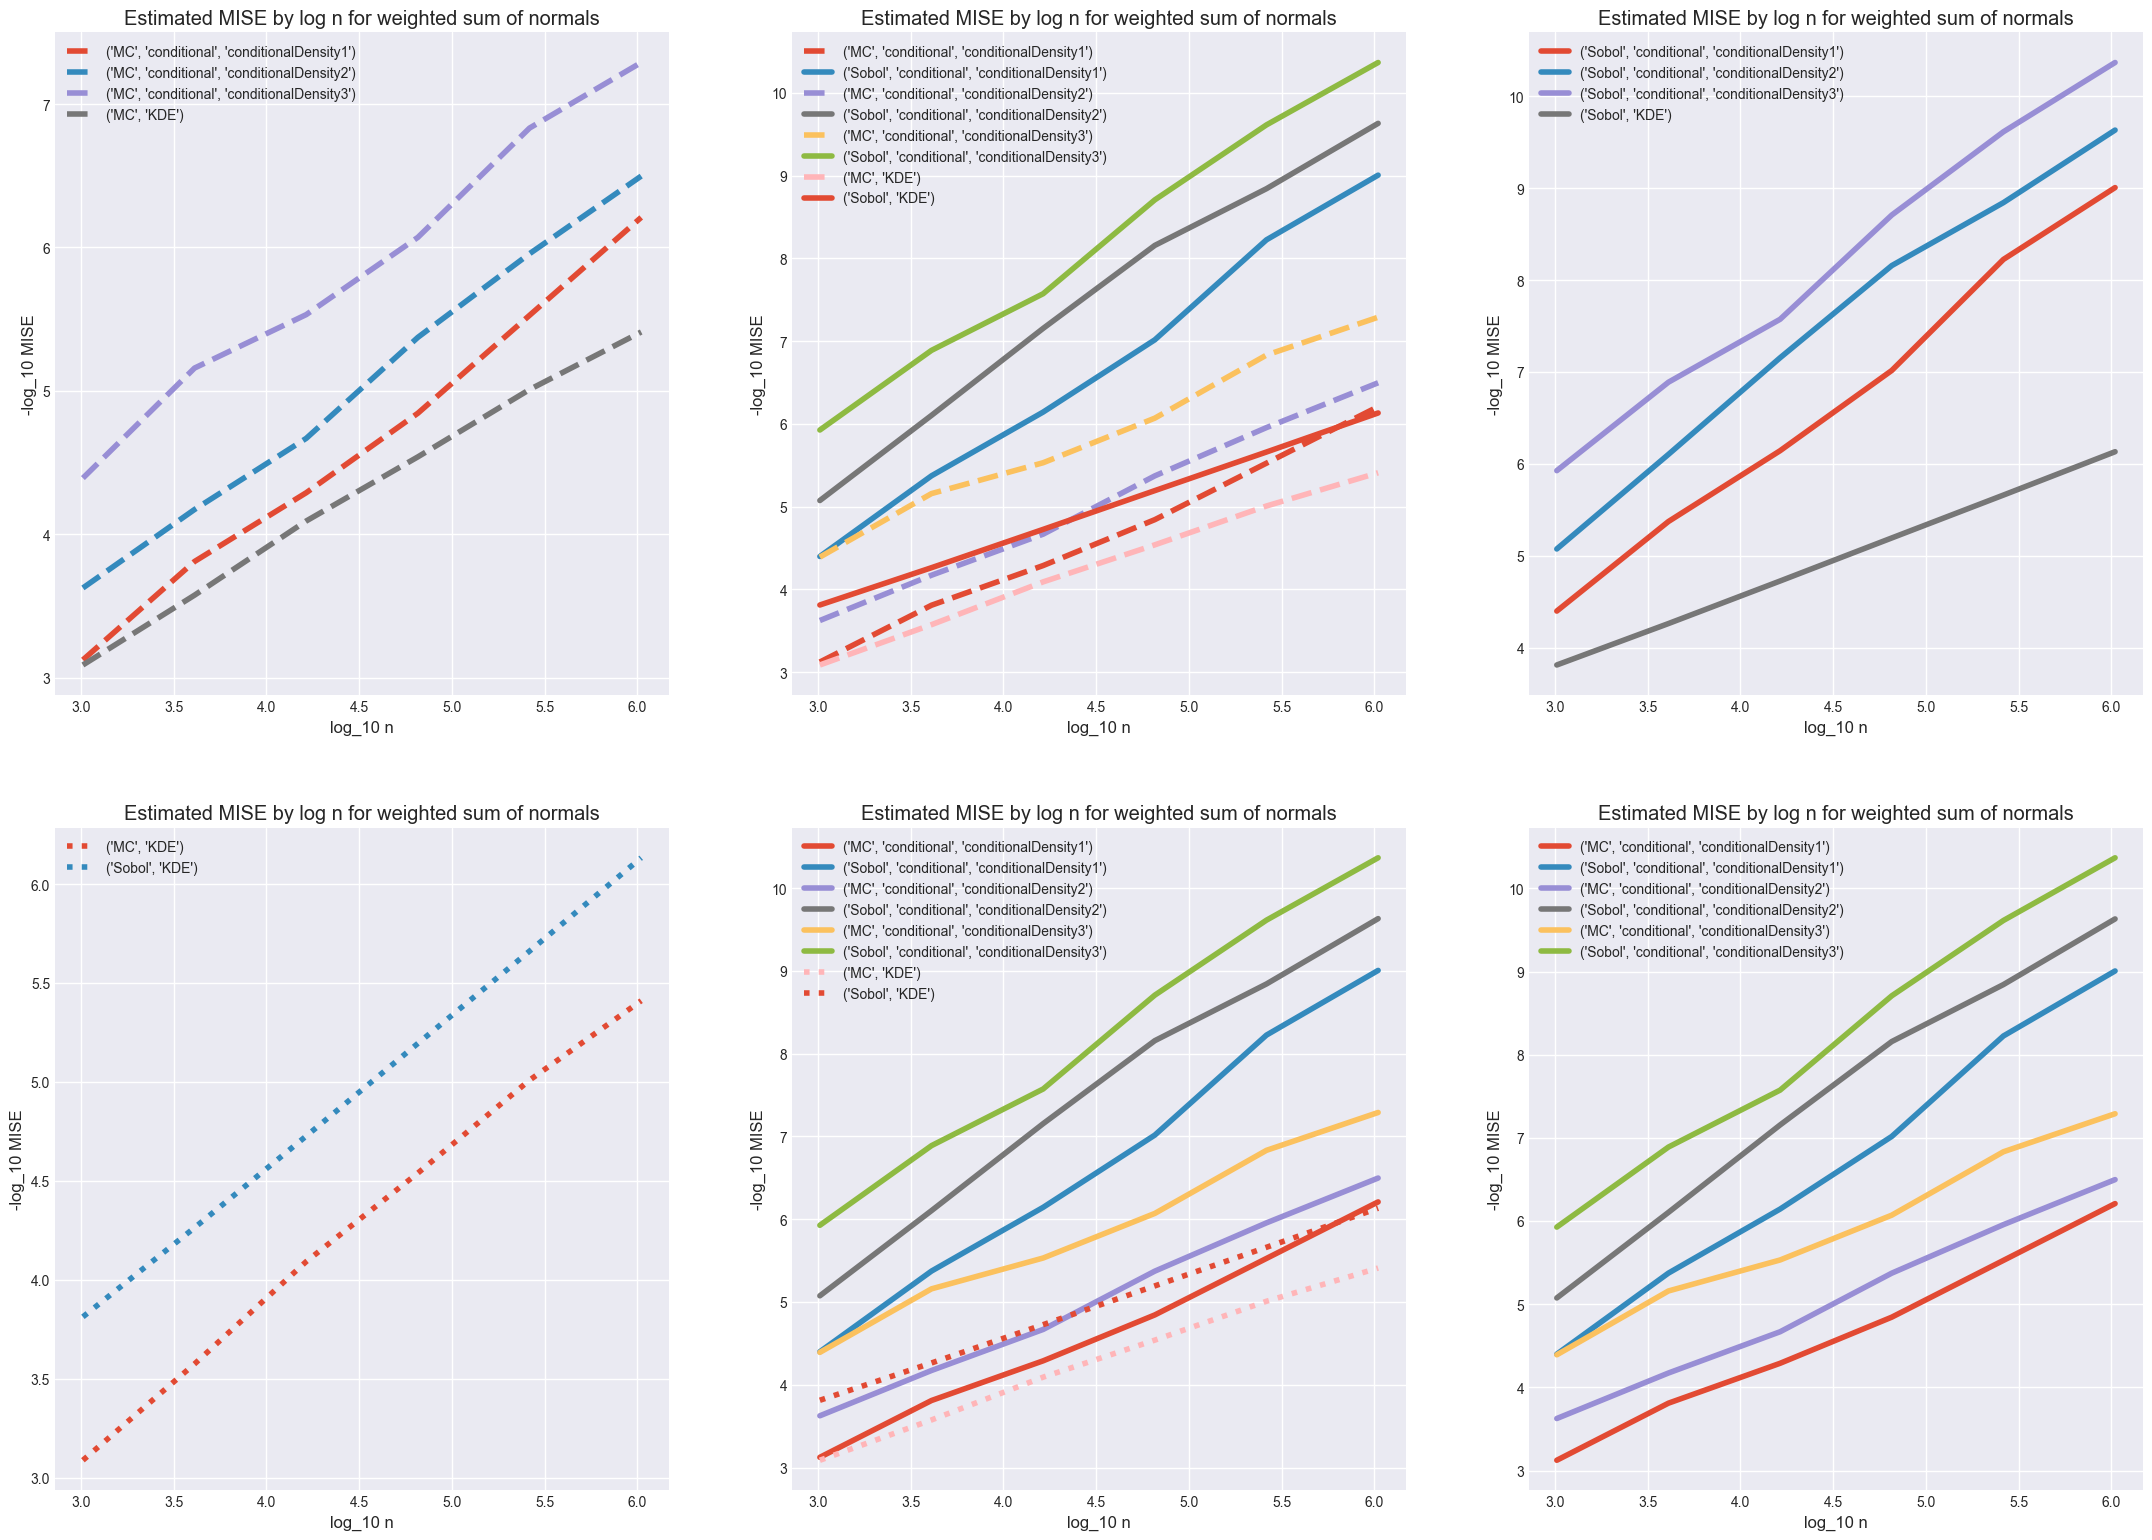

In [63]:
xvals = np.array(range(10, 21, 2)) * np.log10(2)
mpl.style.use('seaborn-v0_8-darkgrid')
fig, ax = plt.subplots(2, 3, figsize = (24,18))
for key in loadedDb:
    yvals = loadedDb[key][0]
    if key[0] == "MC":
        ax[0][0].plot(xvals, yvals, '--',  label = f"{key}")
        ax[0][1].plot(xvals, yvals, '--' , label = f"{key}",)
    elif key[0] == "Sobol":
        ax[0][2].plot(xvals, yvals, label = f"{key}")
        ax[0][1].plot(xvals, yvals, label = f"{key}")
    if key[1] == 'conditional':
        ax[1][2].plot(xvals, yvals, label = f"{key}")
        ax[1][1].plot(xvals, yvals, label = f"{key}")
    if key[1] == 'KDE':
        ax[1][0].plot(xvals, yvals, ':', label = f"{key}")
        ax[1][1].plot(xvals, yvals, ':', label = f"{key}")
    
for i in range(3):
    for j in range(2):
        ax[j][i].legend()
        ax[j][i].set_title("Estimated MISE by log n for weighted sum of normals")
        ax[j][i].set_xlabel("log_10 n")
        ax[j][i].set_ylabel("-log_10 MISE")

